In [3]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import glob
import pickle
from astropy.table import Table
import lmfit
from lmfit.models import VoigtModel
from scipy.interpolate import interp1d
from PyAstronomy import pyasl

import sys
from tqdm import tqdm
from astropy.io import fits
import scipy
sys.path.append('../../../wdtools/')
import wdtools
sys.path.append('../../../')
import WD_models
from bisect import bisect_left
import lmfit
from scipy.ndimage import gaussian_filter

halpha = 6564.61
hbeta = 4862.68
speed_light = 299792458


na1 = 5889.6
na2 = 5895.7

mg = 5176.7

ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52

ca2k = 3934.777

ch = 4302

plt.rcParams.update({'font.size': 18})
#%matplotlib inline
from matplotlib.colors import LogNorm
from astropy.io import ascii

Using TensorFlow backend.
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [4]:
sigma = 2 # Angstrom
convolve = True

In [5]:
sp = wdtools.SpecTools()
lamgrid = np.linspace(3800, 9000, 10000)
def get_spectrum(source_id):
    path = '../spec/'+str(source_id)+'_spec_0.fits'
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        #raise FileNotFoundError('Spectrum file missing...')
        return np.nan, np.nan
    ## RV Correction and Interpolation
    
    return lam, flux

def cont_norm(wl, fl, centre, window, edge):
    c1 = bisect_left(wl, centre - window)
    c2 = bisect_left(wl, centre + window)
    wl, fl = wl[c1:c2], fl[c1:c2]
    
    mask = np.ones(len(wl))
    mask[edge:-edge] = 0
    mask = mask.astype(bool)

    p = np.polynomial.polynomial.polyfit(wl[mask], fl[mask], 1)
    continuum = np.polynomial.polynomial.polyval(wl, p)
    norm_fl = fl / continuum
    return wl, norm_fl

def rv_corr(wl, fl):
    obs_alpha,_,_, _, _ = sp.find_centroid(wl, fl, halpha, make_plot = False, n_fit = 2, 
                            half_window = 50, debug = False, window_step = 5)

    vr = - 1e-3 * speed_light * (obs_alpha - halpha)/halpha

    fl, shift_wl = pyasl.dopplerShift(wl, fl, vr, edgeHandling = 'fillValue', fillValue = 1)
    return wl, fl

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def logg_to_radius(logg):
    g = 10**logg * 0.01 # to SI
    
    R = radius_sun * 10 ** ( - ((np.log10(g / g_sun) + 0.02) / 0.67))
    return R

interpsda = pickle.load(open('interp/interpsda.p', 'rb'))

def get_sda(teff, logg, alpha = 0):
    wl, fl = lamgrid, 10**interpsda((logg, teff, np.log10(lamgrid)))
    
    if convolve:
        fl = scipy.ndimage.gaussian_filter(fl, sigma)
    return wl, fl

def plot_metals(wl, fl, source = '', teff = 6000, logg = 4.5, alpha = 0):
    
    modelwl, modelfl = get_sda(teff, logg, alpha = alpha)
    
    f = plt.figure(figsize = (10, 15))
    gs = f.add_gridspec(4, 2)
    
    ax1 = f.add_subplot(gs[0, :])
    
    
    idx = bisect_left(wl, 5865)
    plt.plot(wl, fl / fl[idx])
    plt.title(source)
    #plt.title(str(obj['source_id'][0]) + ' (%i, %.1f)'%(teff, logg))
    
    ax2 = f.add_subplot(gs[1, 0])
    
    cwl, cfl = cont_norm(wl, fl, ca2k, 20, 5)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, ca2k, 20, 5)
    plt.plot(cwl, cfl)
    #plt.xlim(3925, 3940)
    #plt.axvline(ca2k, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.title('Ca II K')
    plt.ylim(0.5, 1.3)
    
    
    ax3 = f.add_subplot(gs[1,1])

    
    cwl, cfl = cont_norm(wl, fl, na2, 75, 15)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, na2, 75, 15)
    plt.plot(cwl, cfl)
#     plt.axvline(na1, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(na2, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.5, 1.3)
    plt.title('Na')
    
    ax4 = f.add_subplot(gs[2,0])
    
    cwl, cfl = cont_norm(wl, fl, ca2, 400, 25)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, ca2, 400, 25)
    plt.plot(cwl, cfl)
    plt.xlim(ca1-25, ca3+25)
#     plt.axvline(ca1, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(ca2, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(ca3, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.5, 1.3)
    plt.title('Ca Triplet')
    
    ax5 = f.add_subplot(gs[2,1])
    
    cwl, cfl = cont_norm(wl, fl, ch, 26, 5)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, ch, 26, 5)
    plt.plot(cwl, cfl)
   # plt.xlim(ca1-20, ca3+20)
    plt.ylim(0.5, 1.3)
    plt.title('CH G-Band')
    
    ax6 = f.add_subplot(gs[3,0])
    
    cwl, cfl = cont_norm(wl, fl, 4334, 50, 10)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, 4334, 50, 10)
    plt.plot(cwl, cfl)
   # plt.xlim(ca1-20, ca3+20)
    plt.ylim(0.5, 1.3)
    plt.title('H-Gamma')
    
    ax6 = f.add_subplot(gs[3,1])
    
    cwl, cfl = cont_norm(wl, fl, hbeta, 50, 10)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, hbeta, 50, 10)
    plt.plot(cwl, cfl)
    #plt.axvline(hbeta, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.1, 1.3)
    plt.title('H-Beta')
    
    
    
    plt.tight_layout()
    
    return ax1
#     plt.savefig('mp_stars/' + str(source) + '.png', bbox_inches = 'tight')

In [6]:
table = Table.read('tables/ew_table.fits')

## EMP Candidates

In [7]:
len(table)

10500

In [8]:
## from candidate list on Google Sheets

unknown = [
923068053360267136,
2572124320071981696,
4427787686456496128,
2434705943788272128,
1041117669033018112,
926917477929764608,
881205690025926400,
1543322422520153472,
2823062869583476224,
4448895182975654784,
1214202544663262848,
2757064989066940928,
2540804903154179840,
2294041061855802496]
##known
known = [
3092216989574463616,
290930261314166528,
2779958921396953088,
1276882477044162688,
4190837398756490112,
2782111559005651584,
1184737183522291712,
3740963179636227968,
3976087728282022272,
3890626773968983296,
]

unknown.extend(known)

candidates = unknown

selection = [];

for src in candidates:
    idx = np.argmax(table['source_id'] == src)
    selection.append(idx)
    
selection = np.asarray(selection)

seltable = table[selection]

In [9]:
seltable['Gaia ID'] = seltable['source_id']
seltable['$g$ (mag)'] = np.round(seltable['g'], 1)
seltable['$(g-r)_0$'] = np.round(seltable['g-r_0'], 2)
seltable[r'EW$_{\mathrm{Ca\ II\ K}}\ (\text{\AA})$'] = np.round(seltable['ca2k'], 2)
seltable[r'EW$_{\mathrm{Na\ I}}\ (\text{\AA})$'] = np.round(seltable['na'], 2)
seltable[r'EW$_{\mathrm{Ca\ II, 1}}\ (\text{\AA})$'] = np.round(seltable['ca1'], 2)
seltable[r'EW$_{\mathrm{Ca\ II, 2}}\ (\text{\AA})$'] = np.round(seltable['ca2'], 2)
seltable[r'EW$_{\mathrm{Ca\ II, 3}}\ (\text{\AA})$'] = np.round(seltable['ca3'], 2)

In [10]:
columns = ['Gaia ID',
           '$g$ (mag)',
           '$(g-r)_0$',
           r'EW$_{\mathrm{Ca\ II\ K}}\ (\text{\AA})$',
#            r'EW$_{\mathrm{Na\ I}}\ (\text{\AA})$',
#            r'EW$_{\mathrm{Ca\ II, 1}}\ (\text{\AA})$',
#            r'EW$_{\mathrm{Ca\ II, 2}}\ (\text{\AA})$',
#            r'EW$_{\mathrm{Ca\ II, 3}}\ (\text{\AA})$'
            ]

In [11]:
latexdict = {'tabletype': 'table*',
 'header_start': '\\hline \\hline',
 'header_end': '\\hline',
 'data_end': '\\hline'}

In [12]:
ascii.write(seltable[columns], Writer = ascii.Latex, latexdict = latexdict)

\begin{table*}
\begin{tabular}{cccc}
\hline \hline
Gaia ID & $g$ (mag) & $(g-r)_0$ & EW$_{\mathrm{Ca\ II\ K}}\ (\text{\AA})$ \\
\hline
923068053360267136 & 16.4 & 0.3 & 0.88 \\
2572124320071981696 & 18.0 & 0.29 & 0.66 \\
4427787686456496128 & 17.0 & 0.27 & 0.94 \\
2434705943788272128 & 17.8 & 0.37 & 0.76 \\
1041117669033018112 & 17.0 & 0.22 & 0.88 \\
926917477929764608 & 16.6 & 0.25 & 0.87 \\
881205690025926400 & 17.4 & 0.27 & 0.97 \\
1543322422520153472 & 16.9 & 0.27 & 0.97 \\
2823062869583476224 & 17.8 & 0.22 & 0.96 \\
4448895182975654784 & 17.8 & 0.26 & 0.97 \\
1214202544663262848 & 17.8 & 0.28 & 0.95 \\
2757064989066940928 & 17.5 & 0.21 & 0.84 \\
2540804903154179840 & 16.8 & 0.23 & 0.97 \\
2294041061855802496 & 17.4 & 0.18 & 0.97 \\
3092216989574463616 & 17.1 & 0.24 & 0.51 \\
290930261314166528 & 15.8 & 0.33 & 0.98 \\
2779958921396953088 & 16.9 & 0.29 & 0.71 \\
1276882477044162688 & 16.6 & 0.31 & 0.92 \\
4190837398756490112 & 17.0 & 0.18 & 0.42 \\
2782111559005651584 & 15.5 & 0.27 

In [13]:
pltcands = candidates

selection = [];

for src in pltcands:
    idx = np.argmax(table['source_id'] == src)
    selection.append(idx)
    
selection = np.asarray(selection)

seltable = table[selection]

In [14]:
kflag = np.zeros(len(seltable))
for jj in range(len(seltable)):
    if seltable['source_id'][jj] in known:
        kflag[jj] = 1

kflag = kflag.astype(bool)

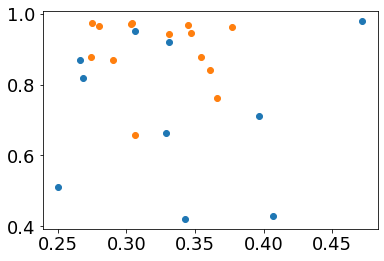

In [15]:
plt.scatter(seltable['g-r'][kflag], seltable['ca2k'][kflag])
plt.scatter(seltable['g-r'][~kflag], seltable['ca2k'][~kflag])

In [17]:
select = (kflag == 0) & (seltable['ca2k'] < 0.7) & (seltable['g-r'] < 0.35)

sum(select)

1

--------------------------------------------------
2572124320071981696
26.582278874000142 8.558845797666637
2.5532234
sdA/F
17.952
0.2856400004550821
0.6583399772644043


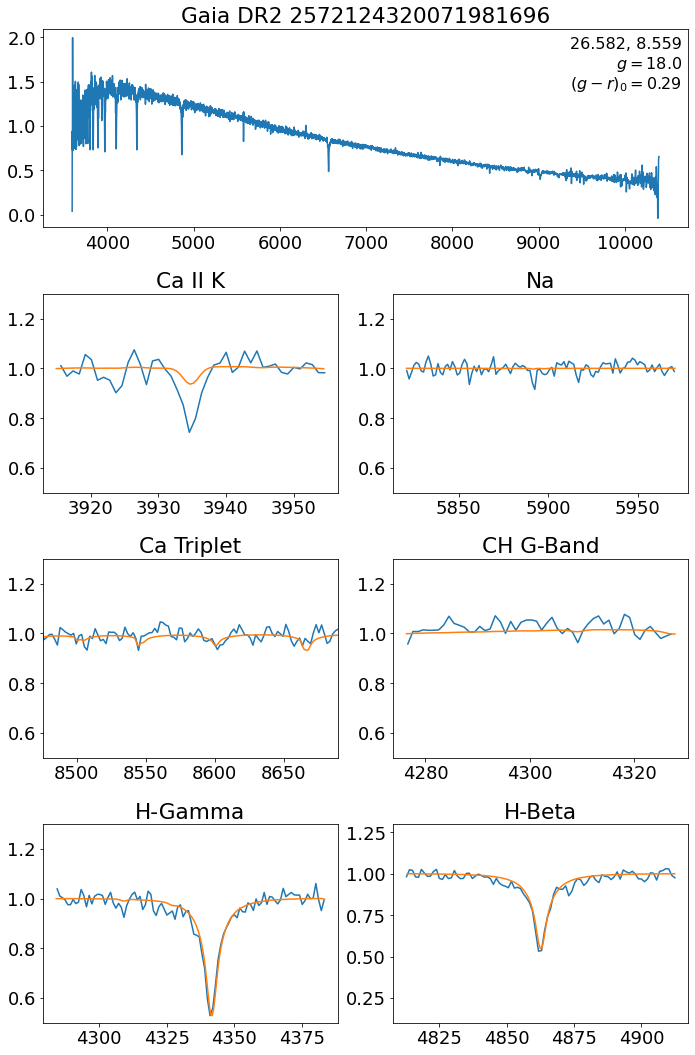

In [18]:
for obj in seltable[select]:
    print('-'*50)
    print(obj['source_id'])
    print(obj['ra'], obj['dec'])
    print(obj['parallax_over_error'])
    print(obj['ty'])
    print(obj['g'])
    print(obj['g-r_0'])
    print(obj['ca2k'])
    
    wl, fl = get_spectrum(obj['source_id'])
    wl, fl = rv_corr(wl, fl)
    
    ax = plot_metals(wl, fl, teff = 6500, logg = 4.5, alpha = 0, source = 'Gaia DR2 ' + str(obj['source_id']))
    ax.text(0.99, 0.9, '%.3f, %.3f' % (obj['ra'], obj['dec']), transform = ax.transAxes, fontsize = 16,
           ha = 'right')
    ax.text(0.99, 0.8, '$g = %.1f$' % obj['g'], transform = ax.transAxes, fontsize = 16, ha = 'right')
    ax.text(0.99, 0.7, '$(g-r)_0 = %.2f$' % obj['g-r_0'], transform = ax.transAxes, fontsize = 16, ha = 'right')

    
    plt.savefig('best/'+str(obj['source_id'])+'.png', bbox_inches = 'tight')
    plt.show()